In [2]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from scipy.sparse import find

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import pickle
import scipy.sparse
import datetime
import scipy.stats as st
django.db.connection.close()

In [2]:
pid = 178
qid = 8145
qid = 8272
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

print(q.doc_set.count())

379897


### Collect the AR5 docs

In [3]:
ar5_docs = Doc.objects.filter(query=6956, content__iregex="\w").exclude(
    pk__in=[
        1461495, # Espinoza 2013
        1626875, # White, 2007
        1622783, # Why is Oliveira, 2007 included?
        1627593, # Killeen 2008
        1627701, # Also, Nepstad and Stickler, 2008
        2093363, # Etter
        2090005, # Nepstad, 2006
        1627734, # Polidoro 2010
        2089982, # Mars, 2007
        2090013, # Randolph 2010
        2093360, # Petney 2012
        2089960, # Wassenaar, 2007 - LUC
        1627733, # Polidoro 2010, very weak - not main conclusion
        2090004, # Veran 2007 - long line fishing
        2089967, # Giri - mangrove database, climate only mentioned in conclusion and with reference
        2089944, # Jellyman - eels
        2091676, # Novelo-Casanova, 2010: Cayman Islands climate??
        2089959, # Bruno, 2007 
        1514856, # de Waroux 2012
        2091680, # Guzman, 2008, we consider the main anthropogenic threats to the coral reefs and communities of the islands are overfishing, sedimentation and tourism
        2089950
    ]
)

ar5_ids = set(ar5_docs.values_list('pk',flat=True))

ar5_docs.count()

256

### Collect the rated documents and merge with the ar5s

In [4]:
qs = Query.objects.filter(pk__in=[8145,7368,8272])
import statistics

def mode_na(x):
    try:
        return statistics.mode([y for y in x if y is not np.NaN])
    except:
        return np.NaN
    
columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

# Majority ratings
dos = DocOwnership.objects.filter(
    query__in=qs, 
    relevant__gt=0,
    doc__content__iregex='\w'
)
dodf = pd.DataFrame.from_dict(dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))
dodf.loc[dodf['relevant']==2,'relevant'] = 0
dodf.loc[dodf['relevant']==3,'relevant'] = np.NaN

gdf = dodf.groupby('doc_id').agg(lambda x: mode_na(x)).reset_index()[['doc_id','relevant']].rename(columns={"doc_id":"id"})
gdf['seen'] = 1
gdf['ar5'] = 0
gdf.loc[pd.isna(gdf['relevant']),'seen'] = np.NaN

# Ar5 docs
ar5_df = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=ar5_ids).values('id')
)
ar5_df['ar5'] = 1
ar5_df['seen'] = 1
ar5_df['relevant'] = 1
ar5_df.head()

seen_df = pd.concat([ar5_df,gdf])
ddf = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=seen_df['id']).values(*columns)
)
seen_df = pd.merge(ddf,seen_df)
print(seen_df.shape)
seen_df.head()


(2457, 8)


,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant
0,374765,Soil respiration (R-s) is the second-largest t...,A cross-biome synthesis of soil respiration an...,apparent Q(10); aridity index; drought; meta-a...,[Biodiversity Conservation; Ecology; Environme...,0,1.0,0.0
1,471951,Many of the largest wildfires in US history bu...,Medieval warming initiated exceptionally large...,wildfire; climate change; Medieval Climate Ano...,[Multidisciplinary Sciences],0,1.0,1.0
2,552782,Recent hydro-climatological trends and variabi...,Characterisation of hydroclimatological trends...,Bayesian change point; trend detection; Double...,[Water Resources],0,1.0,1.0
3,694549,The effects of climate change on biodiversity ...,Climate change surpasses land-use change in th...,forest fragmentation; global change; mammal di...,[Biology; Ecology; Evolutionary Biology],0,1.0,1.0
4,405676,Climate change forced by anthropogenic activit...,Relating climatic attributes and water resourc...,None,[Environmental Sciences; Limnology; Water Reso...,0,1.0,1.0


### Collect all the other unrated documents

In [5]:
unseen_docs = q.doc_set.filter(
    content__iregex='\w',
).exclude(pk__in=seen_df['id'])

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(375908, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,1520670,The aim of the present study was to test the c...,"Radial oxygen loss, photosynthesis, and nutrie...",Biomass; Nutrient removal; Photosynthesis; Rad...,"[Ecology; Engineering, Environmental; Environm...",0,0
1,1520738,Background: Air pollutants in Iceland's capita...,Hydrogen sulfide and particle matter levels as...,Obstructive pulmonary diseases; Pharmaceutical...,"[Environmental Sciences; Public, Environmental...",0,0
2,472095,QuestionsWhat factors control broad-scale vari...,Factors driving structure of natural and anthr...,Agricultural edge; Boundary abruptness; Clear-...,[Plant Sciences; Ecology; Forestry],0,0
3,1521082,"During the last glacial termination, the solub...",Large climate-driven changes of oceanic oxygen...,None,"[Geosciences, Multidisciplinary]",0,0
4,472094,[1] The impact of climate change on U. S. surf...,How does climate change contribute to surface ...,None,[Meteorology & Atmospheric Sciences],0,0


In [6]:
django.db.connection.close()
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)
y = df['relevant']

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_tag = Tag.objects.get(query__project=p,title="random sample 1")
r_index = df[(df['id'].isin(r_tag.doc_set.values_list('pk',flat=True))) & (df['seen']==1)].index
print(df.shape)
df.head()

(378365, 8)


,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant
0,1783633,Physicochemical properties and chemism of atmo...,Chemism of Atmospheric Precipitation as a Cons...,atmospheric immission; precipitation; acid rai...,[Environmental Sciences],NaN,0.0,0.0
1,1455384,Wetlands occur where biotic and abiotic condit...,High altitude montane wetland vegetation class...,Platberg; Inselberg; Phytosociology; Hydrophyt...,[Plant Sciences],NaN,0.0,0.0
2,1340101,The atmospheric forcing on the Barents Sea ice...,Atmospheric forcing on the Barents Sea winter ...,None,[Meteorology & Atmospheric Sciences],NaN,0.0,0.0
3,1461135,An important prerequisite to better understand...,River-aquifer exchange fluxes under monsoonal ...,River-aquifer exchange fluxes; Heat as a natur...,"[Engineering, Civil; Geosciences, Multidiscipl...",NaN,0.0,0.0
4,1344041,"Pacific coast, until recent work provided data...",Fishing in Peru between 10000 and 3750 BP,Peru; early and mid-Holocene; pre-ceramic peri...,[Anthropology; Archaeology],NaN,0.0,0.0


In [87]:
physical_tags = Tag.objects.filter(query__in=qs,id__gt=5177)
pdos = DocOwnership.objects.filter(tag__in=physical_tags,relevant__gt=0).values_list('doc__id',flat=True)
physical_index = df[df['id'].isin(list(pdos))].index
len(physical_index)

1523

In [88]:
dudf = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        doc__pk__in=seen_df['id'],category__project=p,category__level=16
    ).values('user__username','doc__id','category__level','category__name')
)
dudf['v'] = 1
dudf['cname'] =  dudf['category__level'].astype(str) + " - " + dudf['category__name']#
dudf = dudf.drop(columns=['category__level','category__name'])
dudf_wide = dudf.pivot_table(index=['doc__id','user__username'],columns="cname", values="v").fillna(0)
print(dudf_wide.shape)
gudf = dudf_wide.groupby(['doc__id']).agg(lambda x: st.mode(x)[0][0]).reset_index()
dudf_wide_r = dudf_wide.reset_index()
dudf_wide_r.columns = ["doc__id",'user__username'] + list(dudf_wide.columns)
dudf_expanded = dudf_wide_r.melt(id_vars=["doc__id","user__username"]).head()
print(gudf.shape)
gudf.tail()

(170, 9)
(170, 10)


cname,doc__id,16 - Climate Impact attribution,16 - Climate attribution,16 - Climate event attribution,16 - Experimental evidence,16 - Future/modelled impacts,16 - Impact event attribution,16 - No Climate Impact attribution,16 - Unclear,16 - Weather sensitivity
165,2320284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
166,2348732,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
167,2348990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
168,2360767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
169,2364116,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
df = pd.merge(df, gudf.rename(columns={"doc__id":"id"})[['id','16 - Future/modelled impacts']], how="left").fillna(0)
df.loc[(df['relevant']==1) & (df['16 - Future/modelled impacts']==1),"relevant"] = 0 
print(df.shape)
df.head()

(378365, 9)


,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,16 - Future/modelled impacts
0,1783633,Physicochemical properties and chemism of atmo...,Chemism of Atmospheric Precipitation as a Cons...,atmospheric immission; precipitation; acid rai...,[Environmental Sciences],0.0,0.0,0.0,0.0
1,1455384,Wetlands occur where biotic and abiotic condit...,High altitude montane wetland vegetation class...,Platberg; Inselberg; Phytosociology; Hydrophyt...,[Plant Sciences],0.0,0.0,0.0,0.0
2,1340101,The atmospheric forcing on the Barents Sea ice...,Atmospheric forcing on the Barents Sea winter ...,0,[Meteorology & Atmospheric Sciences],0.0,0.0,0.0,0.0
3,1461135,An important prerequisite to better understand...,River-aquifer exchange fluxes under monsoonal ...,River-aquifer exchange fluxes; Heat as a natur...,"[Engineering, Civil; Geosciences, Multidiscipl...",0.0,0.0,0.0,0.0
4,1344041,"Pacific coast, until recent work provided data...",Fishing in Peru between 10000 and 3750 BP,Peru; early and mid-Holocene; pre-ceramic peri...,[Anthropology; Archaeology],0.0,0.0,0.0,0.0


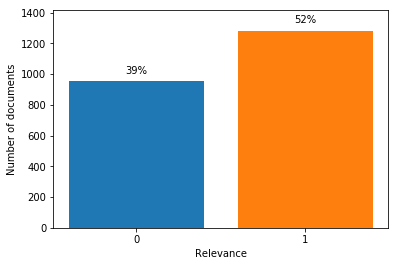

In [90]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
y = df['relevant']
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')

## Vectorize

In [91]:
revectorize = False
retransform = False
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,1),
        min_df=20, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{q.id}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{q.id}.npz', X)
else:
    with open (f'../data/vec_{q.id}.pickle','rb') as f:
        vec = pickle.load(f)
        if retransform:
            X = vec.transform(df['content'].astype("str"))
            scipy.sparse.save_npz(f'../data/X_{q.id}.npz', X)
        else:
            X = scipy.sparse.load_npz(f'../data/X_{q.id}.npz')

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [92]:
revectorize = True
seen_vector = True

if seen_vector:
    if revectorize:
        unseen_sample = unseen_index[random.sample(range(len(unseen_index)),10000)]
        vec = TfidfVectorizer(
            ngram_range=(1,2),
            min_df=5, max_df=0.8, strip_accents='unicode', 
            max_features=50000,
            tokenizer=snowball_stemmer()
        )

        vec.fit(df.loc[unseen_sample.union(seen_index),'content'].astype("str"))   
        X = vec.transform(df['content'].astype("str"))
        with open (f'../data/vec_seen_{q.id}.pickle','wb') as f:
            pickle.dump(vec, f)
        import scipy.sparse
        scipy.sparse.save_npz(f'../data/X_seen_{q.id}.npz', X)
    else:
        with open (f'../data/vec_{q.id}.pickle','rb') as f:
            vec = pickle.load(f)
            X = scipy.sparse.load_npz(f'../data/X_{q.id}.npz')

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [93]:
X

<378365x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 72584521 stored elements in Compressed Sparse Row format>

In [377]:
from sklearn.model_selection import KFold

y = df['relevant']
now = datetime.datetime.now()

from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
]

clf_models, df = lu.cross_validate_models(X, y, clf_models, seen_index, n_splits=10, df = df)

1
2
3
4
5
6
7
8
9
10


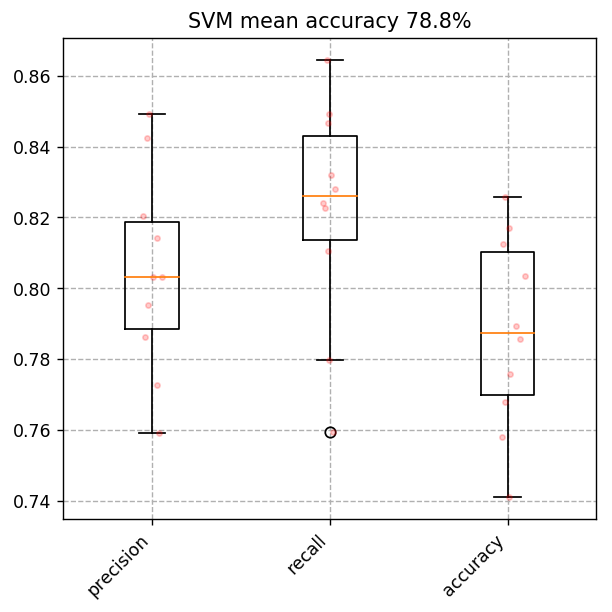

In [378]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(clf_models),dpi=125,figsize=(5,5),sharey=True)              
lu.plot_model_output(clf_models,  ['p','r','e'], fig, [axs])
for ax in [axs]:
    ax.set_xticklabels(["precision","recall","accuracy"])
fig.tight_layout()
plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()

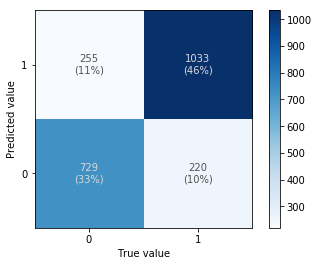

In [379]:
from sklearn.metrics import confusion_matrix
y_pred = [round(x) for x in df.loc[seen_index,'y_k_prediction']]
y_pred_prob = df.loc[seen_index,'y_k_prediction']
y_true = df.loc[seen_index,'relevant']


cm = confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(cm,norm=None,allprop=False):
    fig, ax = plt.subplots()
    
    if norm is not None:
        cm = cm/cm.sum(axis=norm)[:,None]

    mat = ax.imshow(cm, cmap="Blues",origin="lower")    

    for j, c in enumerate([0,1]):
        for k, c in enumerate([0,1]):
            n  = cm[j,k]
            if n > cm.mean():
                color="#d9d9d9"
            else:
                color="#525252"
            if norm is not None:
                ax.text(j,k, f"{cm[j,k]:.0%}",ha="center",color=color, va="center")
            elif allprop:
                ax.text(j,k, f"{cm[j,k]}\n({cm[j,k]/cm.sum():.0%})",ha="center",color=color,va="center")
            else:
                ax.text(j,k, f"{cm[j,k]}",ha="center",color=color, va="center")

    ax.set_xticks([0,1])
    ax.set_yticks([0,1])

    ax.set_xlabel("True value")
    ax.set_ylabel("Predicted value")
    
    cbar = fig.colorbar(mat, ax=ax)
    
    if norm is not None:
        cbar.set_label(f'% of {["Predicted","True"][norm]} values')
    
plot_confusion_matrix(cm,allprop=True)



plt.savefig(f'../plots/prediction_models/relevance_confusion.pdf',bbox_inches="tight")
#cbar.set_label("% of True values")

In [ ]:
plot_confusion_matrix(cm,norm=1)
plt.savefig(f'../plots/prediction_models/relevance_confusion_true.pdf',bbox_inches="tight")

In [ ]:
plot_confusion_matrix(cm,norm=0)
plt.savefig(f'../plots/prediction_models/relevance_confusion_pred.pdf',bbox_inches="tight")

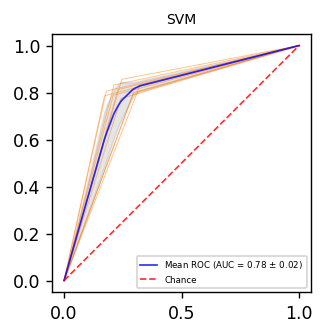

In [59]:
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for j, model in enumerate(clf_models):
    ax = fig.add_subplot(2,3,j+1)
    mean_fpr = np.linspace(0, 1, 100)
    mean_auc = np.mean(model[f'auc'])
    std_auc = np.std(model[f'auc'])
    tprs = []
    for i in range(len(model['i'])):
        viz = ax.plot(
            model[f'fpr'][i],
            model[f'tpr'][i],
            lw=0.5,
            alpha=0.5,
            color=f"C1"
        )
        interp_tpr = interp(mean_fpr, model[f'fpr'][i], model[f'tpr'][i])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    ax.plot(mean_fpr, mean_tpr, color='b',
    label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
    lw=1, alpha=.8)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
        label='Chance', alpha=.8)

    ax.legend(fontsize=5)
    ax.set_aspect("equal")
    ax.set_title(model['title'],fontsize=8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')
        
fig.tight_layout()

## Uncertainty

In [162]:
y_true.shape

(2237,)

In [169]:
y_pred_prob = np.array(y_pred_prob)
y_pred_prob.shape

(2237,)

In [170]:
idx = y_pred_prob.argsort()
y_pred_sorted = np.take(y_pred_prob, idx)
y_true_sorted = np.take(y_true, idx)
y_true_sorted.shape

(2237,)

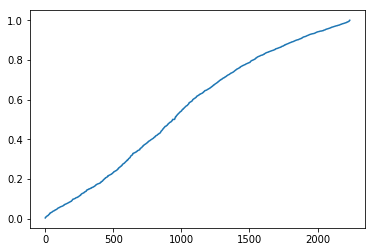

In [176]:
fig, ax = plt.subplots()
ax.plot(y_pred_sorted)

In [215]:
errors = y_true_sorted - y_pred_sorted
errors = np.array(errors)

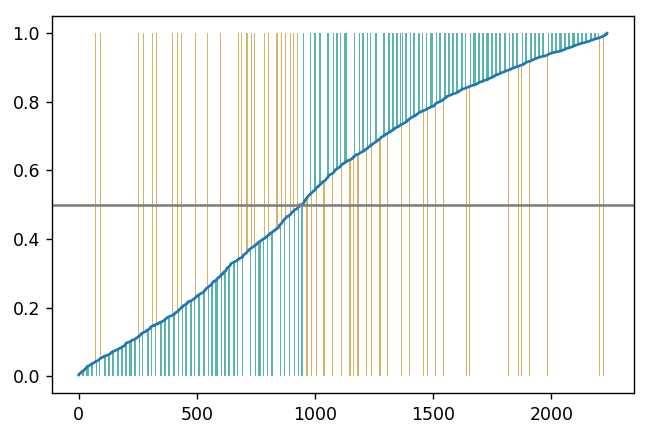

In [216]:
fig, ax = plt.subplots(dpi=125)
ax.plot(y_pred_sorted)
colors = []
for e in errors:
    if abs(e)>0.5:
        colors.append("#d8b365")
    else:
        colors.append("#5ab4ac")
        
ax.bar(range(len(errors)),errors,bottom=y_pred_sorted,width=0.5,color=colors)
ax.axhline(0.5,c="grey")

In [293]:
np.std(errors)

0.38552798428451984

In [291]:
np.std(np.concatenate((errors,errors)))

0.38552798428451984

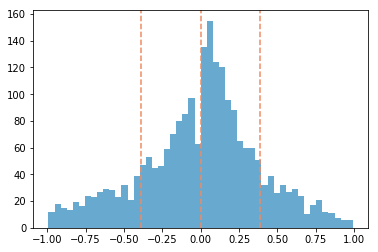

In [282]:
fig, ax = plt.subplots()
ax.hist(errors, bins=50,color="#67a9cf")
m = np.mean(errors)
std = np.std(errors)
ax.axvline(m,ls="--",color="#ef8a62")
ax.axvline(m+std,ls="--",color="#ef8a62")
ax.axvline(m-std,ls="--",color="#ef8a62")



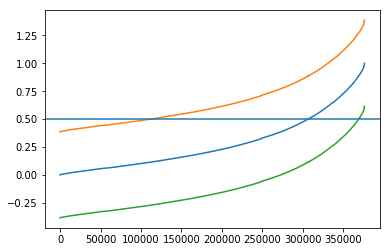

In [289]:
fig, ax = plt.subplots()
y_pred_unseen = np.sort(y_preds[0])
ax.plot(y_pred_unseen)
ax.plot(y_pred_unseen+std)
ax.plot(y_pred_unseen-std)
ax.axhline(0.5)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


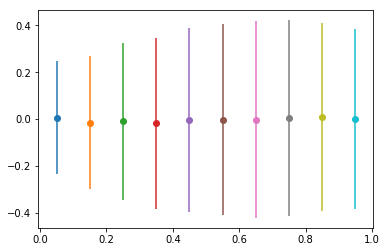

In [234]:
fig, ax = plt.subplots()
q_size = 0.1
for q in range(1,round(1/q_size+1)):
    print(q*q_size)
    idx = np.argwhere(y_pred_sorted<q*q_size)
    x_errors = np.take(errors, idx)
    m = np.mean(x_errors)
    std = np.std(x_errors)
    ax.scatter(q*q_size-q_size/2,m)
    ax.errorbar(q*q_size-q_size/2,m,yerr=std)
    


plt.show()

# TPs FPS

In [74]:
fp = df[(df['relevant']==0) & (df[f'y_k_prediction']>0.5)]
print(fp.shape)
django.db.connection.close()
n = 0
limit = 5
for i, row in fp.sort_values('y_k_prediction',ascending=False).head(100).iterrows():
    d = Doc.objects.get(pk=row['id'])
    if not d.docownership_set.filter(user=1,tag__title__icontains="random").exists():
        continue
    n+=1
    if n<limit:
        continue
    if n>limit+5:
        print("finishing")
        break
    print()
    print(row['title'])
    print(row['content'])
    print(row['id'])
    print(row['y_k_prediction'])
    print(d.docownership_set.filter(query__in=qs).values('user__username','relevant','finish','tag__title'))

(251, 11)

Strong El Nino events during the early Holocene: stable isotope evidence from Peruvian sea shells
Intrashell oxygen and carbon stable isotope profiles ( delta(18)O, delta(13)C) were established for Mesodesma donacium shells from the preceramic archaeological site, Quebrada de los Burros in coastal southern Peru, to reconstruct the sea- surface temperature ( SST) variations and to estimate changes of the El Nino- Southern Oscillation ( ENSO) interannual variability from the early Holocene to the present. Very strong oxygen isotopic excursions attributed to El Nino events are evident in three shells dated between 9 and 7.9 ka. This indicates that short and strong warm events were breaking the mean cooler surface conditions ( 2 - 3degreesC cooler compared with today SSTs) in relation with an intense upwelling system. At 4.8 ka, slightly lower mean SST ( cooler than today by 0.7degreesC) and a reduced seasonality confirms the previous hypothesis of a weak ENSO variability at thi

In [56]:
ids = []

docs = Doc.objects.filter(pk__in=ids)

for d in docs:
    print(d.docownership_set.filter(user=1).update(relevant=1))


1
1
1
1
1


In [78]:
fn = df[(df['relevant']==1) & (df[f'y_k_prediction']<0.5)]
print(fn.shape)
for i, row in fn.sort_values('y_k_prediction',ascending=True).head(15).tail(5).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print()
    print(row['title'])
    print(row['content'])
    print(row['id'])
    print(row['y_k_prediction'])
    print(d.docownership_set.filter(query__in=qs).values('user__username','relevant','finish'))

(219, 11)

The role of environmental driving factors in historical and projected carbon dynamics of wetland ecosystems in Alaska
Wetlands are critical terrestrial ecosystems in Alaska, covering similar to 177,000 km(2), an area greater than all the wetlands in the remainder of the United States. To assess the relative influence of changing climate, atmospheric carbon dioxide (CO2) concentration, and fire regime on carbon balance in wetland ecosystems of Alaska, a modeling framework that incorporates a fire disturbance model and two biogeochemical models was used. Spatially explicit simulations were conducted at 1-km resolution for the historical period (1950-2009) and future projection period (2010-2099). Simulations estimated that wetland ecosystems of Alaska lost 175 Tg carbon (C) in the historical period. Ecosystem C storage in 2009 was 5,556 Tg, with 89% of the C stored in soils. The estimated loss of C as CO2 and biogenic methane (CH4) emissions resulted in wetlands of Alaska incr

In [ ]:
# make these irrelevant
ids = [1306727]

# Test on random sample

In [294]:
django.db.connection.close()
r_index = df[(df['id'].isin(r_tag.doc_set.values_list('pk',flat=True))) & (df['seen']==1)].sample(200).index
nr_index = seen_index.difference(r_index)
print(len(nr_index), len(r_index))

2037 200


In [304]:
from sklearn.model_selection import KFold

y = df['relevant']
now = datetime.datetime.now()

from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

random_val = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            max_iter=500,
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

random_val, test_preds = lu.cross_validate_models(X, y, random_val, nr_index, n_splits=4, test_index=r_index)

1
2
3
4


In [313]:
test_preds = test_preds[:4,:,1]

In [315]:
b = np.sum(test_preds, axis = 0)
idx = b.argsort()
test_preds_sorted = np.take(test_preds, idx, axis=1)

0.3377222474571721
0.3334407924874775
0.344347391673984
0.3413267287615979

0.3413267287615979


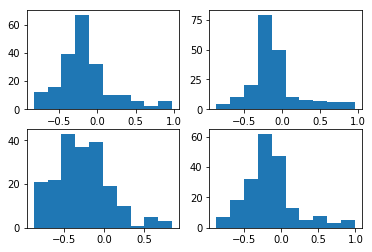

In [324]:
fig = plt.figure()
y_true = y[r_index]
all_errors = None
for i in range(test_preds.shape[0]):
    ax = fig.add_subplot(2,2,i+1)
    errors = np.take(y_true, idx) - test_preds_sorted[i,:]
    if all_errors is None:
        all_errors = errors
    else:
        all_errors = np.concatenate((all_errors,errors))
    print(np.std(errors))
    ax.hist(errors)
    
print()
print(np.std(errors))


In [325]:
len(all_errors)

800

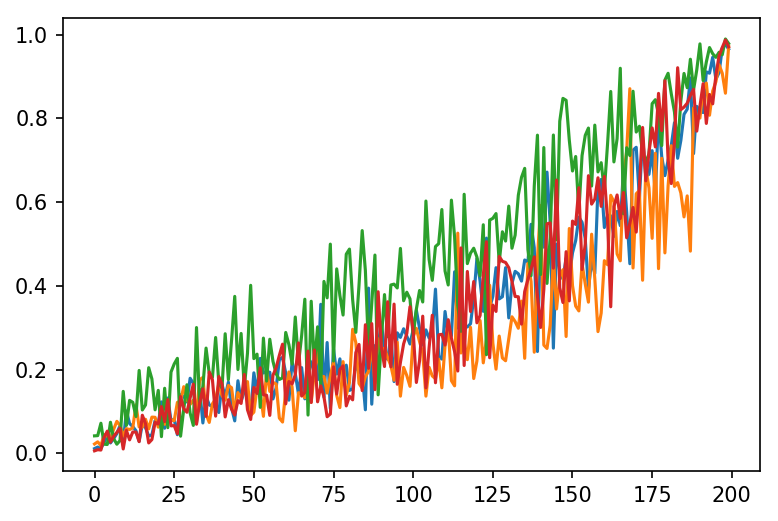

In [318]:
fig, ax = plt.subplots(dpi=150)

for i in range(test_preds.shape[0]):
    ax.plot(test_preds_sorted[i,:])

In [314]:
fig, ax = plt.subplots(dpi=150)

mean_pred = np.mean(y_preds_sorted, axis=0)
std_pred = np.std(y_preds_sorted, axis=0)

ax.plot(mean_pred, color='r', label="Mean")

preds_upper = np.minimum(mean_pred + std_pred, 1)
preds_lower = np.maximum(mean_pred - std_pred, 0)

ax.fill_between(range(len(mean_pred)), preds_upper, preds_lower, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

lb = preds_upper[np.where(preds_upper>0.5)].shape[0]
ub = preds_lower[np.where(preds_lower>0.5)].shape[0]
mb = mean_pred[np.where(mean_pred>0.5)].shape[0]

s = f'{mb:,} ({ub:,}-{lb:,})\n relevant documents predicted'

ax.plot([np.argwhere(preds_upper>0.5)[0][0]*0.66,np.argwhere(preds_upper>0.5)[0][0]],[0.6,0.5],c="grey",ls="--")
ax.plot([np.argwhere(preds_upper>0.5)[0][0]*0.66,np.argwhere((preds_lower>0.5) & (preds_lower < 0.501))[-1][0]],[0.6,0.5],c="grey",ls="--")
ax.text(np.argwhere(preds_upper>0.5)[0][0]*0.66,0.6,s,ha="right",va="bottom",bbox=props)

ax.set_xlabel('Documents')
ax.set_ylabel('Predicted relevance')

ax.legend()

(4, 200)

In [ ]:
b = np.sum(y_preds, axis = 0)
idx = b.argsort()
y_preds_sorted = np.take(y_preds, idx, axis=1)

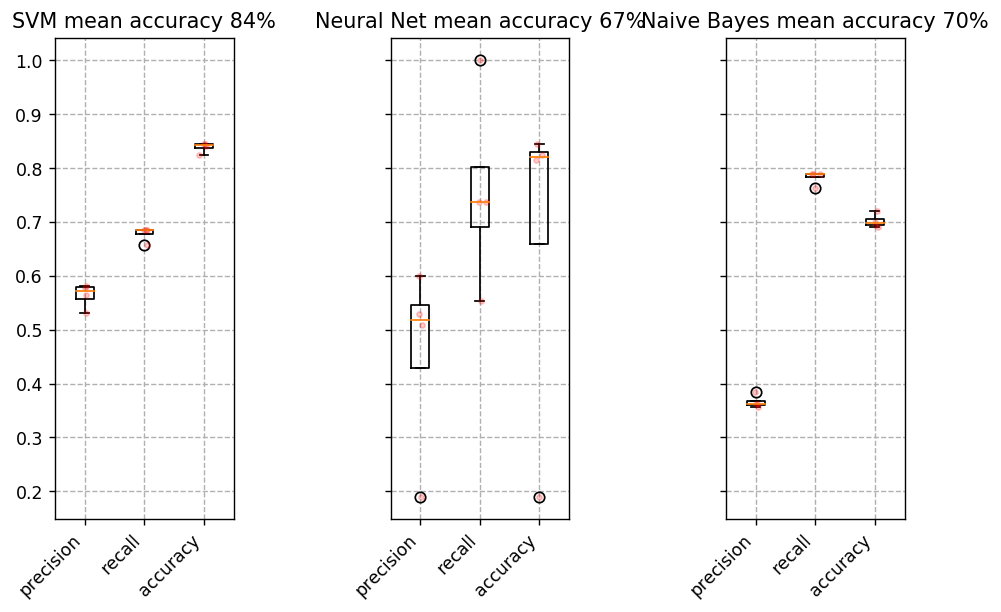

In [300]:
fig, axs = plt.subplots(1, len(random_val),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(random_val,  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()

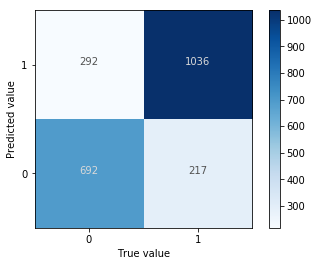

In [301]:
from sklearn.metrics import confusion_matrix
y_pred = [round(x) for x in df.loc[seen_index,'y_k_prediction']]
y_pred_prob = df.loc[seen_index,'y_k_prediction']
y_true = df.loc[seen_index,'relevant']

cm = confusion_matrix(y_true, y_pred)

#confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)

fig, ax = plt.subplots()

mat = ax.imshow(cm, cmap="Blues",origin="lower")

for j, c in enumerate([0,1]):
    for k, c in enumerate([0,1]):
        n  = cm[j,k]
        if n > 500:
            color="#d9d9d9"
        else:
            color="#525252"
        ax.text(j,k, f"{cm[j,k]}",ha="center",color=color)
        
ax.set_xticks([0,1])
ax.set_yticks([0,1])

ax.set_xlabel("True value")
ax.set_ylabel("Predicted value")

cbar = fig.colorbar(mat, ax=ax)

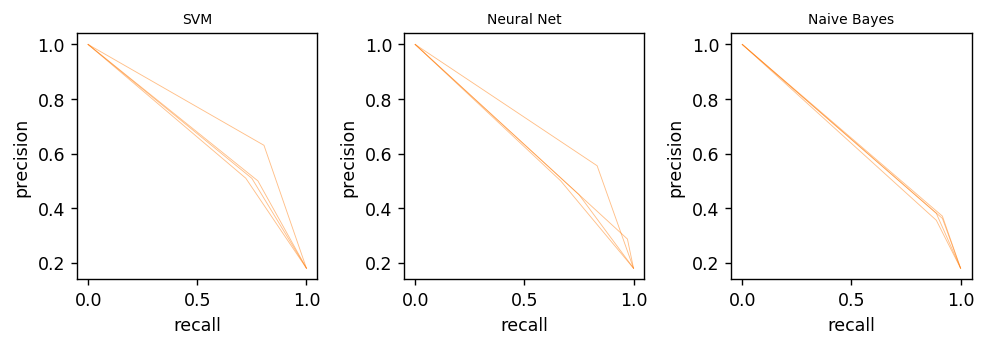

In [100]:
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for j, model in enumerate(clf_models):
    ax = fig.add_subplot(2,3,j+1)
    mean_fpr = np.linspace(0, 1, 100)
    mean_auc = np.mean(model[f'auc'])
    std_auc = np.std(model[f'auc'])
    tprs = []
    for i in range(len(model['i'])):
        viz = ax.plot(
            model[f'rec'][i],
            model[f'prec'][i],
            lw=0.5,
            alpha=0.5,
            color=f"C1"
        )
    ax.set_ylabel('precision')
    ax.set_xlabel('recall')
    ax.set_title(model['title'],fontsize=8)
        
fig.tight_layout()

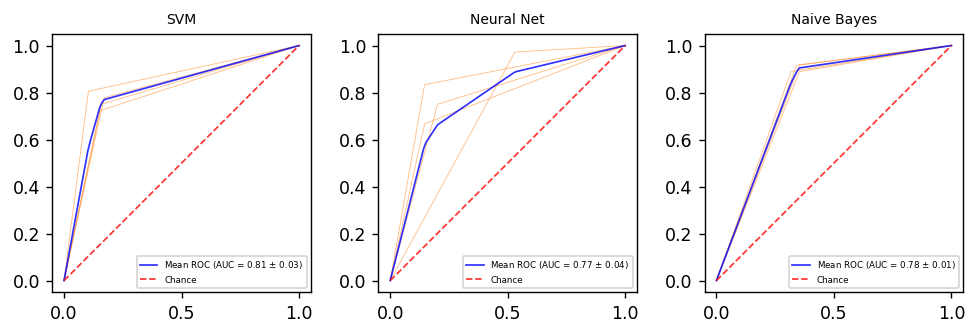

In [101]:
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for j, model in enumerate(clf_models):
    ax = fig.add_subplot(2,3,j+1)
    mean_fpr = np.linspace(0, 1, 100)
    mean_auc = np.mean(model[f'auc'])
    std_auc = np.std(model[f'auc'])
    tprs = []
    for i in range(len(model['i'])):
        viz = ax.plot(
            model[f'fpr'][i],
            model[f'tpr'][i],
            lw=0.5,
            alpha=0.5,
            color=f"C1"
        )
        interp_tpr = interp(mean_fpr, model[f'fpr'][i], model[f'tpr'][i])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    ax.plot(mean_fpr, mean_tpr, color='b',
    label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
    lw=1, alpha=.8)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
        label='Chance', alpha=.8)

    ax.legend(fontsize=5)
    ax.set_aspect("equal")
    ax.set_title(model['title'],fontsize=8)
        
fig.tight_layout()

## Predict unseen and set up a new sample

In [105]:
kf = KFold(n_splits=10)
kfs = kf.split(X[seen_index],y[seen_index])
y_preds = []
for k_train, k_test in kfs:
    clf = SVC(kernel='linear',class_weight='balanced',probability=True)
    k_train = seen_index[k_train]
    clf.fit(X[k_train],y[k_train])
    y_preds.append(clf.predict_proba(X[unseen_index])[:,1])


In [112]:
y_preds = np.array(y_preds)
y_preds

array([[0.08319855, 0.53486392, 0.64808583, ..., 0.08398811, 0.07136683,
        0.10011053],
       [0.09042526, 0.39650883, 0.55301227, ..., 0.09878623, 0.05316861,
        0.07637304],
       [0.08816797, 0.52253874, 0.57597627, ..., 0.08658007, 0.06903625,
        0.11798706],
       ...,
       [0.081207  , 0.54318843, 0.41805391, ..., 0.08858209, 0.06592253,
        0.08824462],
       [0.06332599, 0.53775123, 0.46857788, ..., 0.07952119, 0.03251821,
        0.05344955],
       [0.08297649, 0.52880783, 0.55047767, ..., 0.11497938, 0.07285263,
        0.07504759]])

In [272]:
np.save("../data/y_preds.npz",y_preds)

In [5]:
y_preds = np.load("../data/y_preds.npz.npy")
mean_pred = np.mean(y_preds, axis=0)
std_pred = np.std(y_preds, axis=0)
preds_upper = np.minimum(mean_pred + std_pred, 1)
preds_lower = np.maximum(mean_pred - std_pred, 0)



NameError: name 'df' is not defined

In [ ]:

df.loc[unseen_index,'mean_prediction']= mean_pred
df.loc[unseen_index,'std_prediction'] = std_pred
df.loc[unseen_index,'lower_pred'] = preds_lower
df.loc[unseen_index,'upper_pred'] = preds_upper

df.to_csv('../data/doctables/all_relevance.csv',index=False)

In [6]:
b = np.sum(y_preds, axis = 0)
idx = b.argsort()
y_preds_sorted = np.take(y_preds, idx, axis=1)



In [122]:
y_preds_sorted[0,:].shape

(375908,)

In [3]:
y_preds = np.load("../data/y_preds.npz.npy")

(375908,)
(375908,)
(375908,)
(375908,)
(375908,)
(375908,)
(375908,)
(375908,)
(375908,)
(375908,)


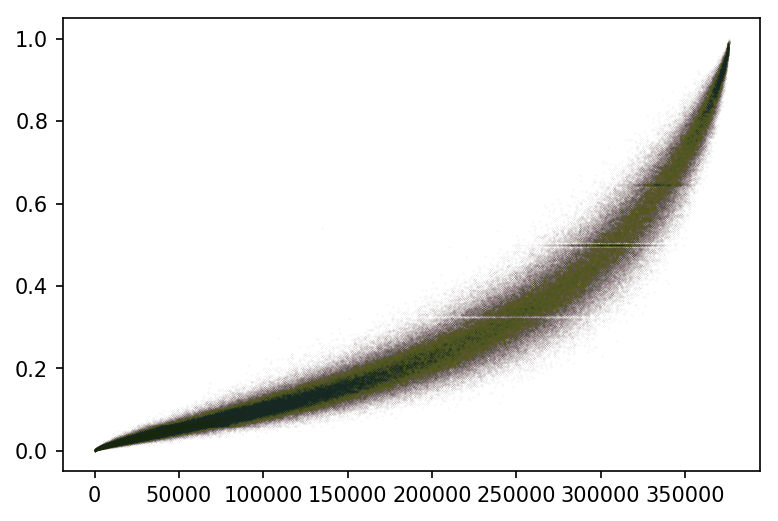

In [136]:
fig, ax = plt.subplots(dpi=150)
for i in range(y_preds_sorted.shape[0]):
    k_pred = y_preds_sorted[i,:]
    print(k_pred.shape)
    ax.scatter(range(len(kpred)),kpred,s=0.01,alpha=0.01)

In [138]:
mean_pred

0.5690657130084935

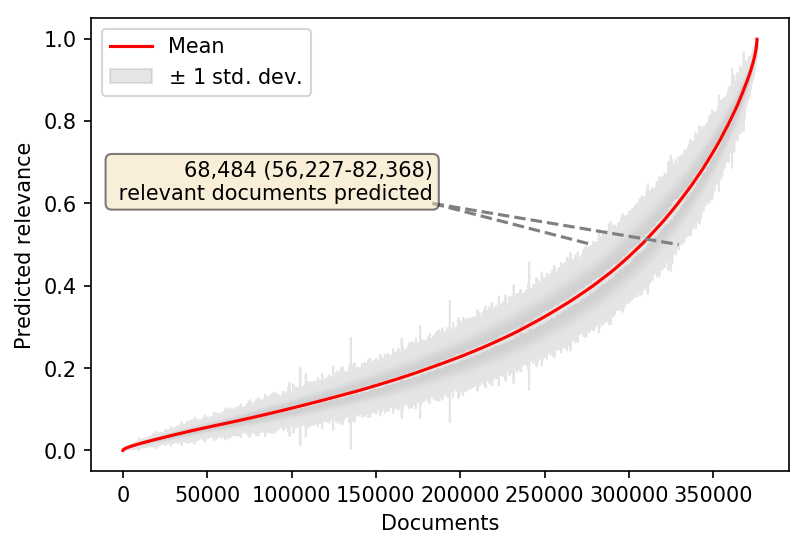

In [7]:
fig, ax = plt.subplots(dpi=150)

mean_pred = np.mean(y_preds_sorted, axis=0)
std_pred = np.std(y_preds_sorted, axis=0)

ax.plot(mean_pred, color='r', label="Mean")

preds_upper = np.minimum(mean_pred + std_pred, 1)
preds_lower = np.maximum(mean_pred - std_pred, 0)

ax.fill_between(range(len(mean_pred)), preds_upper, preds_lower, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

lb = preds_upper[np.where(preds_upper>0.5)].shape[0]
ub = preds_lower[np.where(preds_lower>0.5)].shape[0]
mb = mean_pred[np.where(mean_pred>0.5)].shape[0]

s = f'{mb:,} ({ub:,}-{lb:,})\n relevant documents predicted'

ax.plot([np.argwhere(preds_upper>0.5)[0][0]*0.66,np.argwhere(preds_upper>0.5)[0][0]],[0.6,0.5],c="grey",ls="--")
ax.plot([np.argwhere(preds_upper>0.5)[0][0]*0.66,np.argwhere((preds_lower>0.5) & (preds_lower < 0.501))[-1][0]],[0.6,0.5],c="grey",ls="--")
ax.text(np.argwhere(preds_upper>0.5)[0][0]*0.66,0.6,s,ha="right",va="bottom",bbox=props)

ax.set_xlabel('Documents')
ax.set_ylabel('Predicted relevance')

ax.legend()
plt.savefig(f'../plots/prediction_models/predictions_unseen.png',bbox_inches="tight")
plt.savefig(f'../plots/prediction_models/predictions_unseen.pdf',bbox_inches="tight")

In [252]:
preds_lower[200000:200005]

array([0.20193739, 0.20023485, 0.18281876, 0.20134345, 0.18306872])

In [158]:
print(preds_upper[np.where(preds_upper>0.5)].shape)
print(preds_lower[np.where(preds_lower>0.5)].shape)

(82368,)
(56227,)


In [52]:
clf = MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

clf = SVC(kernel='linear',class_weight='balanced',probability=True)

clf.fit(X[seen_index],y[seen_index])
y_pred = clf.predict_proba(X[unseen_index])
df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

66831
375908


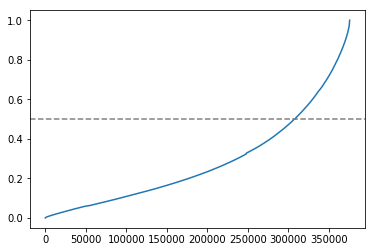

In [53]:
plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])

p_rel_index = df[df['prediction']>0.5].index

plt.show()

In [19]:
#df[df['prediction']>0.0][['id','prediction']].to_csv('../data/doctables/predicted_relevant_all_ids.csv')
df.to_csv('../data/doctables/all_relevance.csv',index=False)

In [16]:
django.db.connection.close()
tagged_docs = set(Doc.objects.filter(tag__query__in=qs).values_list('pk',flat=True))
len(tagged_docs)
import datetime
#now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

newtag = False

if newtag:
    tag = Tag(
        title="predicted relevant sample {}".format(now),
        query=q
    )
    tag.save()

    max_docs = 10
    docs_added = 0
    prel = True
    for i, row in df.query('prediction>0.8').sample(frac=1).reset_index(drop=True).iterrows():
        if row['id'] in tagged_docs:
            continue
        d = Doc.objects.get(id=row['id'])
        if docs_added < max_docs:
            d.tag.add(tag)
            docs_added+=1
        else:
            break  
        if row['prediction'] < 0.5 and prel:
            print(docs_added)
            prel = False


    tag.update_tag()

In [17]:
df[df['prediction']>0.4]['id'].to_csv('../data/doctables/predicted_relevant_ids.csv')
df[df['prediction']>0.0][['id','prediction']].to_csv('../data/doctables/predicted_relevant_all_ids.csv')

# Just new documents - rated since new criteria and categories

1006


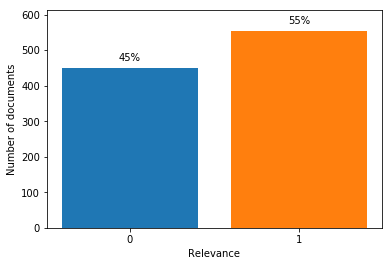

In [41]:
print(len(physical_index))
fig, ax = plt.subplots()
n = len(physical_index)
y = df.loc[physical_index][['relevant']]
for i, (name, group) in enumerate(y.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')

In [42]:
from sklearn.model_selection import KFold

y = df['relevant']
now = datetime.datetime.now()
clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

clf_models_random = cross_validate_models(X, y, clf_models, physical_index)

1
2
3
4
5
6
7
8
9
10


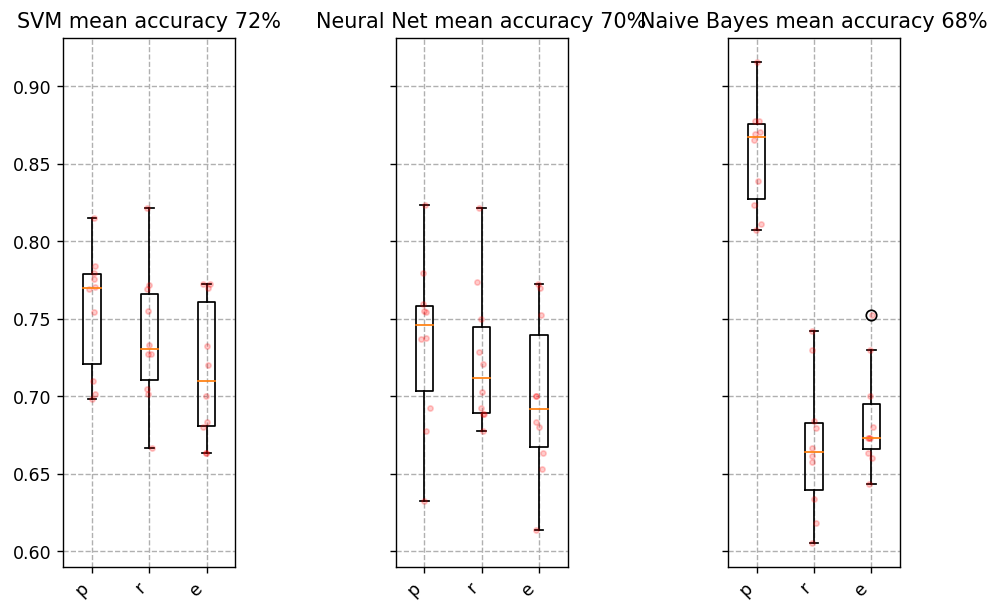

In [43]:
fig, axs = plt.subplots(1, len(clf_models_random),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(clf_models_random,  ['p','r','e'], fig, axs)
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, len(clf_models),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(clf_models,  ['p','r','e'], fig, axs)
fig.tight_layout()
plt.savefig(f'../plots/prediction_models/relevance_prediction_random_{now}.pdf',bbox_inches="tight")
plt.show()

In [14]:
clf = SVC(kernel='linear',class_weight='balanced',probability=True)
clf.fit(X[r_index],y[r_index])
y_pred = clf.predict_proba(X[unseen_index])

In [15]:
df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

19761
316475


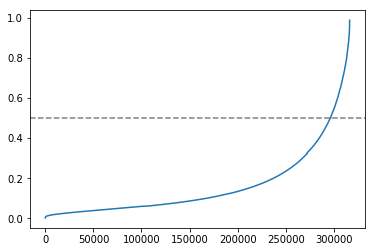

In [16]:
plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])

p_rel_index = df[df['prediction']>0.5].index

plt.show()

In [18]:
tagged_docs = set(Doc.objects.filter(tag__query=q).values_list('pk',flat=True))
len(tagged_docs)

770

In [19]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

tag = Tag(
    title="predicted relevant sample {}".format(now),
    query=q
)
tag.save()

max_docs = 20
docs_added = 0
prel = True
for i, row in df.query('prediction>0.5').sample(frac=1).reset_index(drop=True).iterrows():
    if row['id'] in tagged_docs:
        continue
    d = Doc.objects.get(id=row['id'])
    if docs_added < max_docs:
        d.tag.add(tag)
        docs_added+=1
    else:
        break  
    if row['prediction'] < 0.5 and prel:
        print(docs_added)
        prel = False

    
tag.update_tag()

In [37]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

tag = Tag(
    title="predicted relevant sample {}".format(now),
    query=q
)
tag.save()

max_docs = 250
docs_added = 0
prel = True
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(tag)
            docs_added+=1
        else:
            break  
        if row['prediction'] < 0.5 and prel:
            print(docs_added)
            prel = False

    
tag.update_tag()

In [40]:
model_df = pd.DataFrame(clf_models)
model_df.to_csv(f"../data/doctables/models_rel_{now}.csv",index=False)
df[['id','prediction']].to_csv(f'../data/doctables/predictions_rel_{now}.csv',index=False)